<a href="https://colab.research.google.com/github/sujitojha1/DeepLearning_PyTorch_EVA4/blob/master/EVA4_MNIST_practice_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Practice - MNIST data

## Target

1.   Get the setup right
2.   Set Transforms
3.   Set Basic Working Code
4.   Set Basic Training & Test Loop

## Results


1.   Model size: 6.3 M
2.   Best Training accuracy : 100%
3.   Best Test accuracy: 99.3%


## Analysis



1.   Extremely heavy model for MNIST problem
2.   Model is overfitting, there no room to learn further from training data to improve the test performance





### 1. Import Libraries

In [0]:
# Set for future print function
from __future__ import print_function

# Import PyTorch Libraries
import torch # Base library
import torch.nn as nn # To Define the neural network architecture as object
import torch.nn.functional as F # To define functional operation on NN object
import torch.optim as optim # Optimization function libraries SGD, ADAM
from torchvision import datasets, transforms #Utilizing existing dataset & transforms

# Model summary PyTorch
!pip install torchsummary
from torchsummary import summary

# tqdm - to visualize training progress
from tqdm import tqdm

# Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Creating train and test transforms

In [0]:
# Train phase transforms
train_transforms = transforms.Compose([
                                       transforms.ToTensor(), # To Convert image 0-255 to 0-1
                                       transforms.Normalize((0.1307,),(0.3081,)) # To normalize the data
                                      ])

# Test phase transforms
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
])

### 3. Loading train and test dataset

In [0]:
train = datasets.MNIST('.data/',train=True,download=True, transform=train_transforms)
test = datasets.MNIST('.data/',train=False,download=True,transform=test_transforms)

### 4. Dataloader (arguments, test/train)

In [0]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility 
SEED = 1

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader argument - defining the setting
dataloader_args = dict(shuffle=True, batch_size = 128, num_workers = 4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

# Train data loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)

# Test data loader
test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

### 5. Exploratory Data analysis

#### 5a. Data statistics (Summary)

It is important to understand the data distribution and summary statistics.

In [0]:
# Load train data as numpy array
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[ Train ]')
print('- Numpy Shape:', train.data.cpu().numpy().shape)
print('- Tensor Shape:', train.data.size())
print('- min:',torch.min(train_data))
print('- max:',torch.max(train_data))
print('- mean: ',torch.mean(train_data))
print('- std :', torch.std(train_data))
print('- var:', torch.var(train_data))

#### 5b. Visualize data - get understanding

torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor(9)


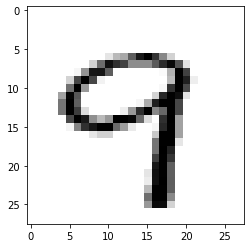

In [17]:
data_iter = iter(train_loader)
images, label = data_iter.next()

print(images.shape)
print(label.shape)

print(label[0])
plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

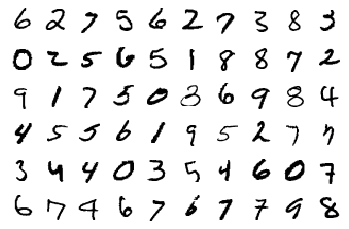

In [18]:
figure = plt.figure()
num_images = 60

data_iter = iter(train_loader)
images, label = data_iter.next()

for index in range(1,num_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

### 6. Defining CNN - architecture and forward propogation

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size= 3, padding = 1) # 1x28x28|32x1x3x3|32x28x28, RF=3
    self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1) # 32x28x28|64x32x3x3|64x28x28, RF=5
    self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2) #64x28x28|2x2|64x14x14, RF=6, J=2
    self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, padding=1) #64x14x14|128x64x3x3|128x14x14, RF=10
    self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1) #128x14x14|256x128x3x3|256x14x14, RF=14
    self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2) #256x14x14|2x2|256x7x7, RF=16
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3) #256x7x7|512x256x3x3|512x5x5, RF=24
    self.conv6 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3) #512x5x5|1024x512x3x3|1024x3x3, RF=32
    self.conv7 = nn.Conv2d(in_channels=1024,out_channels=10,kernel_size=3) #1024x3x3|10x1024x3x3|10x1x1, RF=40

  def forward(self,x):
    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
    x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
    x = F.relu(self.conv6(F.relu(self.conv5(x))))
    x = self.conv7(x)
    x = x.view(-1,10)
    return F.log_softmax(x , dim=1)

### 7. Model Parameter

Can't emphasize on how important viewing Model Summary is. Unfortunately, there is no in-built model visualizer, so we have to take external help

In [20]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print("Neural network passed to :",device)

model = Net().to(device)
summary(model,input_size=(1,28,28))

Neural network passed to : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-----

### 8. Training and testing

In [0]:
# Array initialization to track test and train accuracy and loss
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Training function
def train(model,device,train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  #image count
  correct = 0
  processed = 0

  for batch_idx, (data,target) in enumerate(pbar):
    # get samples
    data, target = data.to(device),target.to(device)

    #Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    #Predict
    y_pred = model(data)

    # Loss calculation
    loss = F.nll_loss(y_pred,target)
    train_losses.append(loss)

    # Backward propagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim = True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss = {loss.item()} Batch_id = {batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model,device,test_loader):
  model.eval()
  test_loss=0
  correct =0

  with torch.no_grad():
    for data,target in test_loader:
      data,target = data.to(device),target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output,target,reduction='sum').item() #sum up batch loss
      pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest Set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset), 100.*correct/len(test_loader.dataset)))
  
  test_acc.append(100.*correct/len(test_loader.dataset))
  

In [30]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
EPOCHS = 20

for epoch in range(EPOCHS):
  print('EPOCH:',epoch)
  train(model,device,train_loader,optimizer,epoch)
  test(model,device,test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss = 0.01626829244196415 Batch_id = 468 Accuracy=86.15: 100%|██████████| 469/469 [00:22<00:00, 22.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0536, Accuracy: 9832/10000 (98.32%)

EPOCH: 1


Loss = 0.026628941297531128 Batch_id = 468 Accuracy=98.31: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0444, Accuracy: 9850/10000 (98.50%)

EPOCH: 2


Loss = 0.048851367086172104 Batch_id = 468 Accuracy=98.88: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0320, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss = 0.045148447155952454 Batch_id = 468 Accuracy=99.20: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0356, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss = 0.006253600120544434 Batch_id = 468 Accuracy=99.35: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0258, Accuracy: 9919/10000 (99.19%)

EPOCH: 5


Loss = 0.04404385760426521 Batch_id = 468 Accuracy=99.47: 100%|██████████| 469/469 [00:22<00:00, 20.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0288, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss = 0.007095774170011282 Batch_id = 468 Accuracy=99.60: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0273, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss = 0.010069022886455059 Batch_id = 468 Accuracy=99.69: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0276, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss = 0.0007088531856425107 Batch_id = 468 Accuracy=99.77: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0310, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss = 0.01642453670501709 Batch_id = 468 Accuracy=99.75: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0275, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss = 0.0075905523262917995 Batch_id = 468 Accuracy=99.81: 100%|██████████| 469/469 [00:22<00:00, 22.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0280, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss = 0.025761326774954796 Batch_id = 468 Accuracy=99.86: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0303, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss = 0.0006995101575739682 Batch_id = 468 Accuracy=99.92: 100%|██████████| 469/469 [00:23<00:00, 21.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0308, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss = 0.00016533334564883262 Batch_id = 468 Accuracy=99.93: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0272, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss = 4.55776862509083e-05 Batch_id = 468 Accuracy=99.96: 100%|██████████| 469/469 [00:23<00:00, 21.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0308, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss = 0.0013808110961690545 Batch_id = 468 Accuracy=99.97: 100%|██████████| 469/469 [00:22<00:00, 21.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0293, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss = 5.4329633712768555e-05 Batch_id = 468 Accuracy=99.99: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0302, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss = 5.575020986725576e-05 Batch_id = 468 Accuracy=100.00: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0310, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss = 9.765227332536597e-06 Batch_id = 468 Accuracy=100.00: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.0314, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss = 1.2497107491071802e-05 Batch_id = 468 Accuracy=100.00: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]



Test Set: Average Loss: 0.0319, Accuracy: 9930/10000 (99.30%)



### 9. Plot training and test results

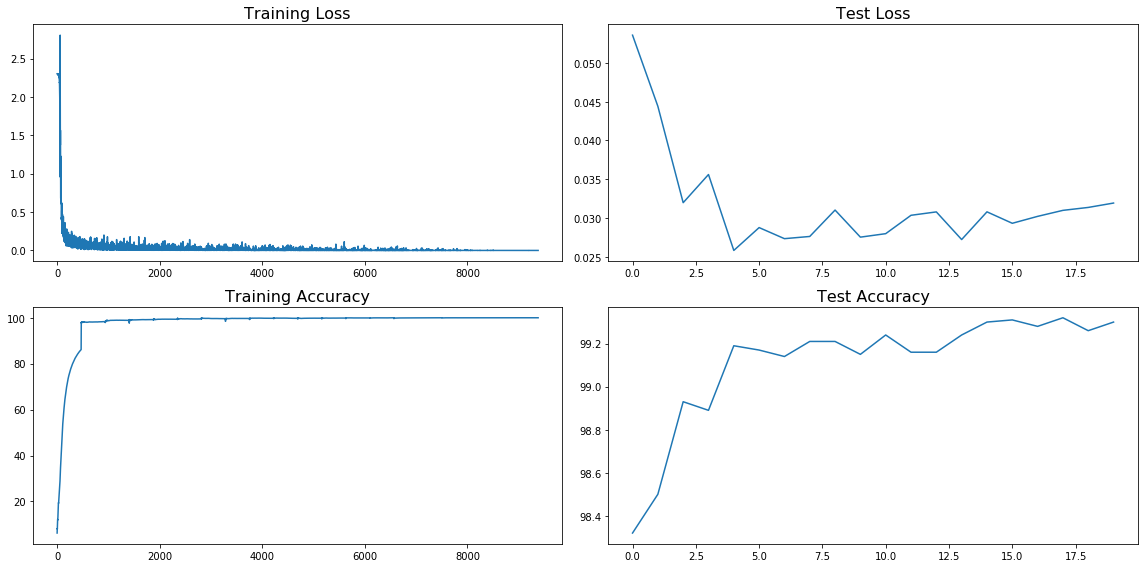

In [38]:
fig, axs = plt.subplots(2,2,figsize=(16,8))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss",fontsize=16)
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy",fontsize=16)
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss",fontsize=16)
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy",fontsize=16)
fig.tight_layout()
fig.show()